### Examine the Data

In [125]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12,5)

# load specific forecasting tools
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse,rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")



In [126]:

# Read the dataset
file_name = 'new_stuckAt1.csv'
# df_raw = pd.read_csv('waterTank_ctrl_stuckAt1.csv', index_col=0, header=0, parse_dates=True)
df_raw = pd.read_csv(file_name, index_col=0, header=0, parse_dates=True)
df_raw.index.freq = 'ms'

df_raw.head()


,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


In [127]:
df_raw.isna().sum()

Tank1WaterLevel    0
Tank2WaterLevel    0
Tank1InFlow        0
Tank2OutFlow       0
wt3_valve          0
Tank3OutFlow       0
Tank2.level        0
dtype: int64

In [128]:
len(df_raw)

20001

In [129]:
df_raw = df_raw.iloc[:18000]

In [130]:
df_raw.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


### Plot the source data

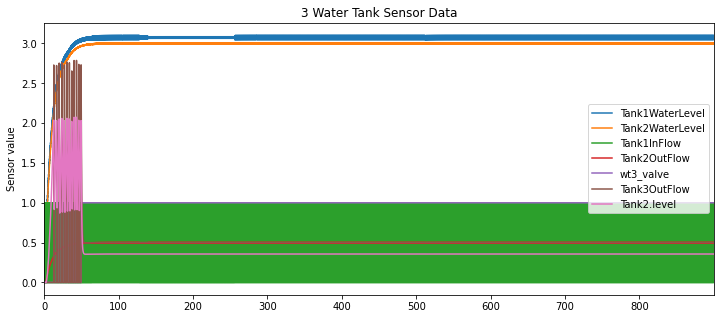

In [131]:
attr = list(pd.read_csv(file_name).columns.values)[1:]   
# ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
title = '3 Water Tank Sensor Data'
ylabel = 'Sensor value'
xlabel = ''

ax = df_raw['Tank1WaterLevel'].plot(legend=True, title=title)
for col in attr[1:]:
    df_raw[col].plot(legend=True)

# df_raw['Tank2WaterLevel'].plot(legend=True)
# df_raw['Tank1InFlow'].plot(legend=True)
# df_raw['Tank2OutFlow'].plot(legend=True)
# df_raw['wt3_valve'].plot(legend=True)
# df_raw['Tank3OutFlow'].plot(legend=True)
# df_raw['Tank2.level'].plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()


In [132]:
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')

In [133]:
adf_test(df_raw['Tank1WaterLevel'])

Augmented Dickey-Fuller Test: 
ADF test statistics    -1.305727e+01
p-value                 2.082284e-24
#lags                   4.400000e+01
#observations           1.795500e+04
critical value (1%)    -3.430714e+00
critical value (5%)    -2.861701e+00
critical value (10%)   -2.566856e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data is Stationary


Take the first order difference of the entire dataframe and re-run the dickey fuller test

In [134]:
# All the correlated features are stationary.
df_raw.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,1.000000e-06,0.000000e+00,0,0.0,0,0.0,0.0
0.05,6.890000e-07,3.110000e-07,0,0.0,0,0.0,0.0
0.10,3.333928e-03,4.050000e-07,1,0.0,0,0.0,0.0
0.15,5.448433e-02,8.850002e-03,1,0.0,0,0.0,0.0
0.20,7.717051e-02,2.949715e-02,0,0.0,0,0.0,0.0


### Normalisation of the dataset

In [135]:
# Read the mean and std used for normalising the golden model
var_df = pd.read_csv("norm_var.csv", index_col=0)
old_means, old_stds = var_df["0"], var_df["1"]

def normalise_series(data, means, stds):
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)


def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


normalised_data = normalise_series(df_raw, old_means, old_stds)

In [136]:
df = normalised_data

In [137]:
# Train Test Split
nobs = 3000
train = df.iloc[:-nobs]
test = df.iloc[-nobs:]
len(train), len(test)

(15000, 3000)

### VAR Model Order Selection

In [138]:
# from statsmodels.tsa.vector_ar.var_model import VAROrderSelection
# Perform order selection using auto-arima
model = VAR(train)
# Select the best order based on a specific criterion (e.g. AIC, BIC)
selected_order = model.select_order()
# Get the selected order (lag length)
order = selected_order.selected_orders['aic']
min_aic_index = order
print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))

Order 42 has the least AIC value. Let us select p = 42 in the modelling


In [139]:
# p = [1,2,3,4,5,6,7] # try with list of 7 p values
# p = list(range(1,20))
# aic, bic = [], []
# for i in p:
#     model = VAR(train)
#     results = model.fit(i)
#     aic.append(results.aic)
#     bic.append(results.bic)
#     print(f'VAR Order {i}')
#     print('AIC: {}'.format(results.aic))
#     print('BIC: {}'.format(results.bic))
#     print()

# min_aic = min(aic)
# min_aic_index = aic.index(min_aic) + 1
# min_bic = min(bic)
# min_bic_index = bic.index(min_bic) + 1
# print('Order {0} has the least AIC value. Let us select p = {0} in the modelling'.format(min_aic_index))


In [140]:
# let's confirm that both the variables are included in the model
model.endog_names

['Tank1WaterLevel',
 'Tank2WaterLevel',
 'Tank1InFlow',
 'Tank2OutFlow',
 'wt3_valve',
 'Tank3OutFlow',
 'Tank2.level']

### Fit the VAR {{min_aic_index}}  model

In [141]:
min_aic_index

42

In [142]:
results = model.fit(min_aic_index)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Jul, 2023
Time:                     11:54:19
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -75.8910
Nobs:                     14958.0    HQIC:                  -76.5932
Log likelihood:           428943.    FPE:                3.84187e-34
AIC:                     -76.9420    Det(Omega_mle):     3.35097e-34
--------------------------------------------------------------------
Results for equation Tank1WaterLevel
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.005807         0.000339          -17.145           0.000
L1.Tank1WaterLevel          0.337082         0.011280           29.883           0.000
L1.Tank2WaterLevel        

### Predict the next 20 values

In [143]:
# For predictions, VAR model uses .forecast() instead of predictions.
lag_order = results.k_ar
lag_order

42

In [144]:
df.head()

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
0.00,-13.751169,-13.647795,-1.001251,-11.718138,-2.764683,-1.531894,-1.265579
0.05,-13.751171,-13.647793,-1.001251,-11.718138,-2.764683,-1.531894,-1.265579
0.10,-13.736104,-13.647793,0.998751,-11.718138,-2.764683,-1.531894,-1.265579
0.15,-13.504895,-13.607095,0.998751,-11.718138,-2.764683,-1.531894,-1.265579
0.20,-13.402350,-13.512143,-1.001251,-11.718138,-2.764683,-1.531894,-1.265579


In [145]:
steps = 20
# z = results.forecast(y=train.values[-lag_order:], steps = 20)
z = results.forecast(y=train.values[-lag_order:], steps=steps)
z

array([[ 0.2391073 ,  0.14081767,  0.99872127,  0.13360229,  0.3636493 ,
         0.02842772, -0.3816534 ],
       [ 0.22768235,  0.16774243, -1.00248338,  0.15808555,  0.36376869,
         0.03200057, -0.38181147],
       [ 0.09227059,  0.16722778, -1.00303232,  0.17457585,  0.36296151,
         0.03271095, -0.38191347],
       [ 0.02615391,  0.1426057 , -0.99116766,  0.15764649,  0.36349405,
         0.03218174, -0.38193088],
       [ 0.16556908,  0.12359014,  1.00115882,  0.12651097,  0.36385655,
         0.03369217, -0.38206419],
       [ 0.23930696,  0.14091802,  0.99598291,  0.13367011,  0.36508756,
         0.03467253, -0.38237199],
       [ 0.1755771 ,  0.17458988, -1.0033825 ,  0.16980297,  0.36370374,
         0.03713008, -0.38280323],
       [ 0.09206634,  0.16714929, -1.00136167,  0.17453209,  0.36515164,
         0.03170921, -0.38288444],
       [ 0.06919322,  0.12958238,  0.99937014,  0.14379335,  0.36118014,
         0.03529371, -0.38292793],
       [ 0.16583189,  0.1236

In [146]:
test

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
time,,,,,,,
750.00,0.239056,0.140814,0.998751,0.133595,0.361705,0.029201,-0.381683
750.05,0.227724,0.167719,-1.001251,0.158064,0.361705,0.029077,-0.381753
750.10,0.092379,0.167226,-1.001251,0.174569,0.361705,0.029151,-0.381711
750.15,0.025990,0.142666,-1.001251,0.157702,0.361705,0.029315,-0.381618
750.20,0.165423,0.123577,0.998751,0.126510,0.361705,0.029390,-0.381576
...,...,...,...,...,...,...,...
899.75,0.204316,0.130090,0.998751,0.127319,0.361705,0.029297,-0.381628
899.80,0.227724,0.167719,-1.001251,0.158064,0.361705,0.029044,-0.381772
899.85,0.131271,0.173739,-1.001251,0.175378,0.361705,0.029087,-0.381747


In [147]:
# idx = pd.date_range(start='1/1/2015', periods=12, freq='MS')
# df_forecast = pd.DataFrame(z, index=idx, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast = pd.DataFrame(z, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
# df_forecast = pd.DataFrame(z, columns=['wt3_valve', 'Tank3OutFlow', 'Tank2.level'])
df_forecast[:5]

,Tank1WaterLevel,Tank2WaterLevel,Tank1InFlow,Tank2OutFlow,wt3_valve,Tank3OutFlow,Tank2.level
0,0.239107,0.140818,0.998721,0.133602,0.363649,0.028428,-0.381653
1,0.227682,0.167742,-1.002483,0.158086,0.363769,0.032001,-0.381811
2,0.092271,0.167228,-1.003032,0.174576,0.362962,0.032711,-0.381913
3,0.026154,0.142606,-0.991168,0.157646,0.363494,0.032182,-0.381931
4,0.165569,0.123590,1.001159,0.126511,0.363857,0.033692,-0.382064


### Plot the results

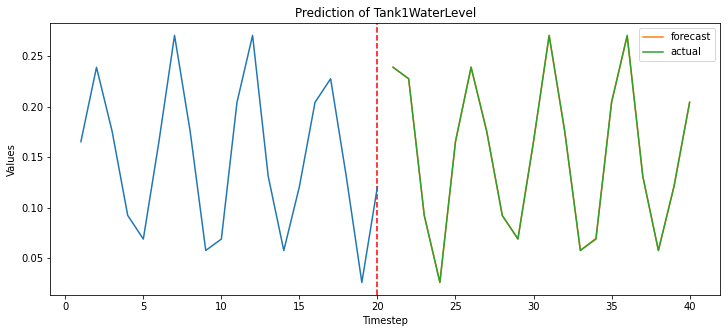

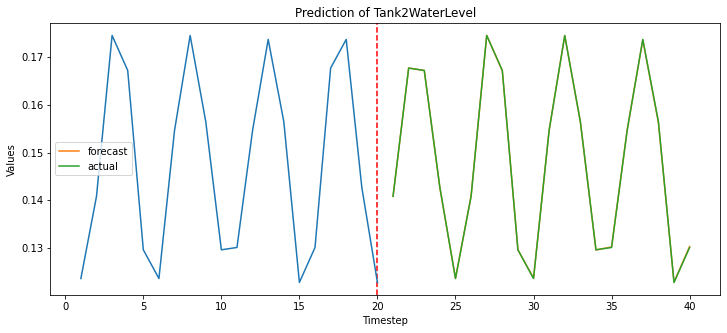

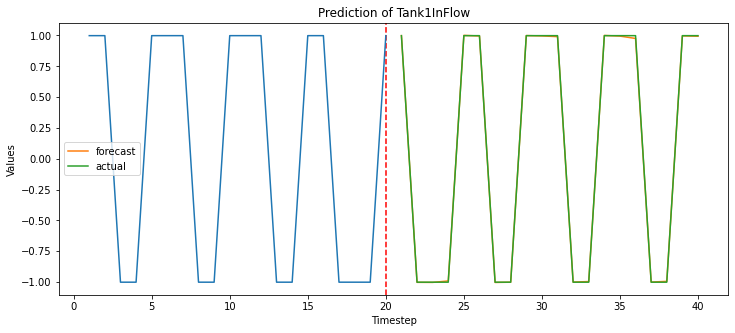

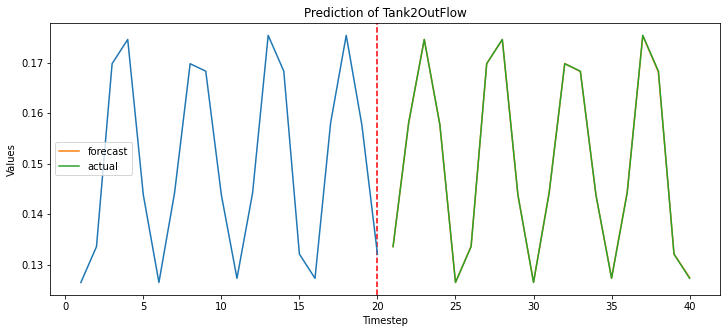

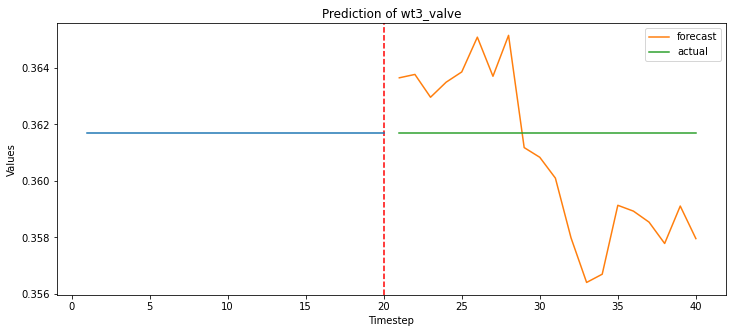

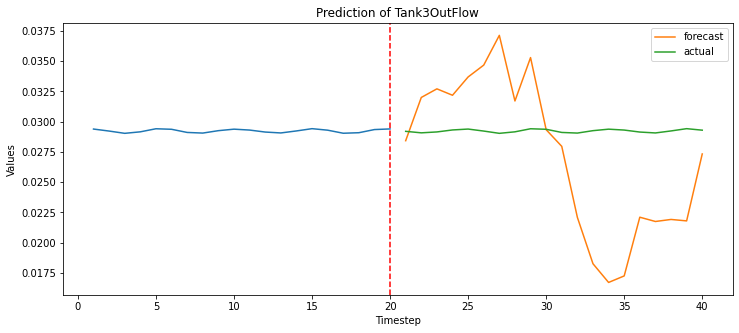

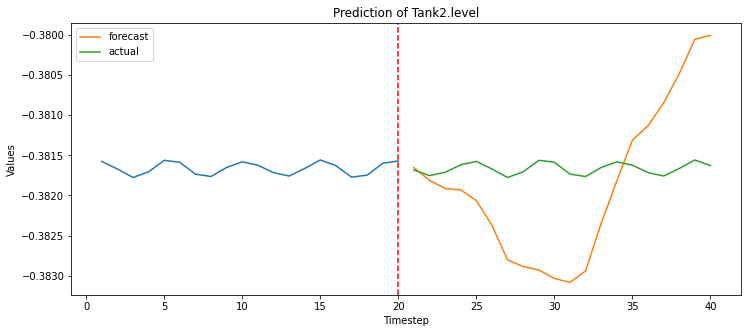

In [148]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
# for i in range(len(attr)):
#     title = "Prediction of {}".format(attr[i])
#     actual_index = pd.Index(list(range(lag_order)))
#     actual = train.iloc[-lag_order:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps)))
#     actual = actual.set_index(actual_index)
#     pred = df_forecast.set_index(index)
#     actual_test = test.iloc[:lag_order+1,:].set_index(index)
#     # draw a vertical line at x=19
#     plt.axvline(x=lag_order, ls='--', color='red')
# #     pred = df_forecast
#     plt.title(title)
#     plt.xlabel("Timestep")
#     plt.ylabel("Values")
#     plt.plot(actual.iloc[:,i])
#     plt.plot(pred.iloc[:,i], label="forecast")
#     plt.plot(actual_test.iloc[:,i], label="actual")
#     plt.legend()
#     plt.show()
    
    
attr = list(pd.read_csv(file_name).columns.values)[1:]   

# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
input_length = 20
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index = pd.Index(list(range(1,input_length+1)))
#     actual = train.iloc[-lag_order:,:] # CORRECT BEFORE EDITING
    actual = train.iloc[-input_length:,:]
    
#     index = pd.Index(list(range(lag_order, lag_order + steps))) # CORRECT BEFORE EDITING
    index = pd.Index(list(range(input_length+1, input_length + steps +1)))
    actual = actual.set_index(actual_index)
    pred = df_forecast.set_index(index)
    actual_test = test.iloc[:input_length,:].set_index(index)
    # draw a vertical line at x=20
#     plt.axvline(x=lag_order, ls='--', color='red') # CORRECT BEFORE EDITING
    plt.axvline(x=input_length, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual.iloc[:,i])
    plt.plot(pred.iloc[:,i], label="forecast")
    plt.plot(actual_test.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

### Model Evaluation

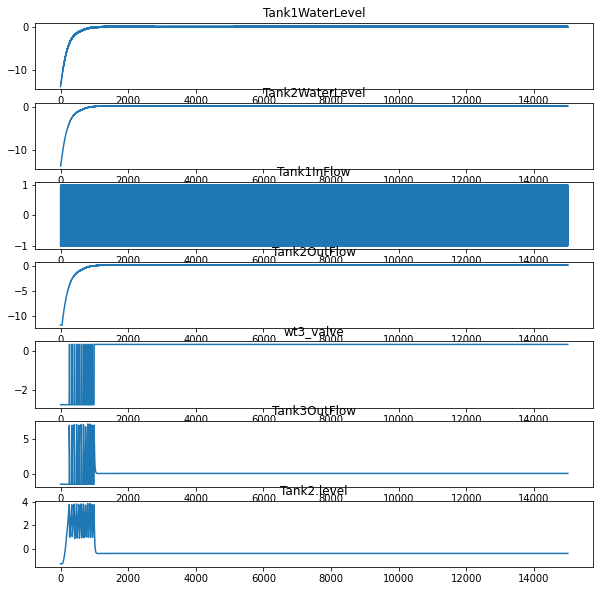

In [149]:
results.plot();

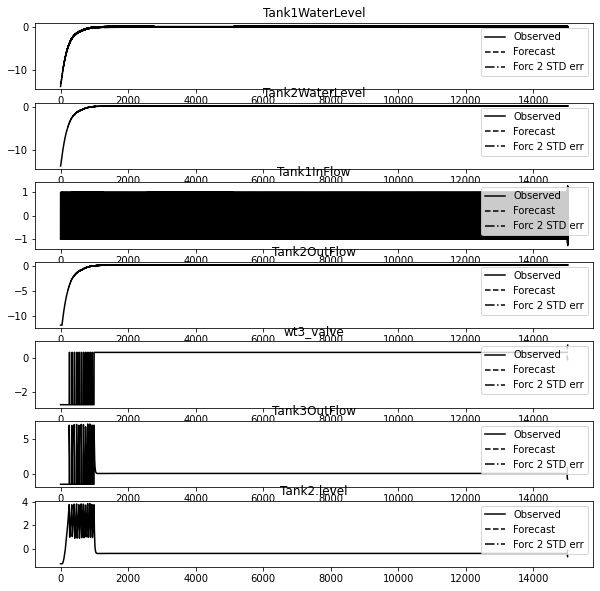

In [150]:
results.plot_forecast(20);

In [151]:
len(df_forecast)

20

In [152]:
len(df['Tank1WaterLevel'].iloc[:steps])

20

### Model Evaluation

In [153]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSE = []
for feat in attr:
    RMSE.append(rmse(pred[feat], actual_test[feat]))

print(RMSE)

[0.0003412348724090953, 9.212729860329774e-05, 0.0064492155602596845, 8.591556615389101e-05, 0.002963880617408992, 0.006630538977126751, 0.00096381988489079]


### Save the model

In [60]:
# Serialize andsave the model
import pickle
import statsmodels.api as sm
with open('var_ctrl_stuckat1.pkl', 'wb') as f:
    pickle.dump(results, f)
print("Model saved!")

Model saved!


In [61]:
print("Stop execution here")
print(error)

Stop execution here


NameError: name 'error' is not defined

### Define the faulty data

In [ ]:
faulty_data = pd.read_csv('test_fault.csv', index_col=0, header=0, parse_dates=True)
faulty_data.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty = faulty_data.iloc[:-num_obs]
test_faulty = faulty_data.iloc[-num_obs:]
len(train_faulty), len(test_faulty)

### Load the model and reconstruct VAR

In [ ]:
with open('var_ctrl_stuckat1.pkl', 'rb') as f:
    params = pickle.load(f)
    
stuckat1_model = sm.tsa.VAR(train)
stuckat1_model.params = params
stuckat1_model_fit = stuckat1_model.fit(min_aic_index)

stuckat1_model_fit.summary()

### Forecast using faulty data

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast = stuckat1_model_fit.forecast(y=train_faulty.values[-lag_order:], steps=20)
# forecast = golden_model_fit.forecast(params, start=len(train), end=len(train)+10)
forecast

In [ ]:
fault_forecast = pd.DataFrame(forecast, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

### Increasing the duration of faults

In [ ]:
faulty_data_extend = pd.read_csv('test_extend.csv', index_col=0, header=0, parse_dates=True)

faulty_data_extend.index.freq = 'MS'
num_obs = 3000

# train_faulty = faulty_data.iloc[-num_obs:]
# test_faulty = faulty_data.iloc[:-num_obs]

train_faulty_extend = faulty_data_extend.iloc[:-num_obs]
test_faulty_extend = faulty_data_extend.iloc[-num_obs:]
len(train_faulty_extend), len(test_faulty_extend)

In [ ]:
# Use the loaded model to make predictions or perform other analyses
forecast_extend = stuckat1_model_fit.forecast(y=train_faulty_extend.values[-lag_order:], steps=20)

In [ ]:
fault_forecast = pd.DataFrame(forecast_extend, columns=['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level'])

attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
for i in range(len(attr)):
    title = "Prediction of {}".format(attr[i])
    actual_index_f = pd.Index(list(range(lag_order)))
    actual_f = train_faulty.iloc[-lag_order:,:]
    
    index_f = pd.Index(list(range(lag_order, lag_order + steps)))
    actual_f = actual_f.set_index(actual_index_f)
    pred_f = fault_forecast.set_index(index_f)
    actual_test_f = test_faulty.iloc[:lag_order+1,:].set_index(index_f)
    # draw a vertical line at x=19
    plt.axvline(x=lag_order, ls='--', color='red')
#     pred = df_forecast
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Values")
    plt.plot(actual_f.iloc[:,i])
    plt.plot(pred_f.iloc[:,i], label="forecast")
    plt.plot(actual_test_f.iloc[:,i], label="actual")
    plt.legend()
    plt.show()

In [ ]:
# attr = ['Tank1WaterLevel', 'Tank2WaterLevel', 'Tank1InFlow', 'Tank2OutFlow', 'wt3_valve', 'Tank3OutFlow', 'Tank2.level']
RMSEf = []
for feat in attr:
    RMSEf.append(rmse(df[feat].iloc[:steps], fault_forecast[feat]))

print(RMSEf)

In [2]:
print("Wallaah")

Wallaah
